## Probability distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

## Load imbalanced dataset

In [2]:
# load imbalanced dataset

data = pd.read_csv('../kdd2004.csv')
# remap target class to 0 and 1
data['target'] = data['target'].map({-1:0, 1:1})

In [3]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [4]:
# balancing ratio

y_train.value_counts() / len(X_train)

0    0.991267
1    0.008733
Name: target, dtype: float64

In [5]:
# number of observations per class

y_train.value_counts()

0    101134
1       891
Name: target, dtype: int64

## Random Forests

In [6]:
rf = RandomForestClassifier(
    n_estimators=100, random_state=0, max_depth=2).fit(X_train, y_train)

# score the test set
probs = rf.predict_proba(X_test)[:, 1]

In [7]:
print('roc-auc on train set: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
print('roc-auc on test set: ', roc_auc_score(y_test, probs))

roc-auc on train set:  0.9514252540056589
roc-auc on test set:  0.9443759064189495


In [8]:
print('Brier Score on train set: ', brier_score_loss(y_train, rf.predict_proba(X_train)[:, 1]))
print('Brier Score on test set: ', brier_score_loss(y_test, probs))

Brier Score on train set:  0.0033725415408792014
Brier Score on test set:  0.003621047973398065


See how loss the Brier Score is, yet, the probability is very uncalibrated as we will see now.

## Calibration Curve

In [9]:
def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Logit')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

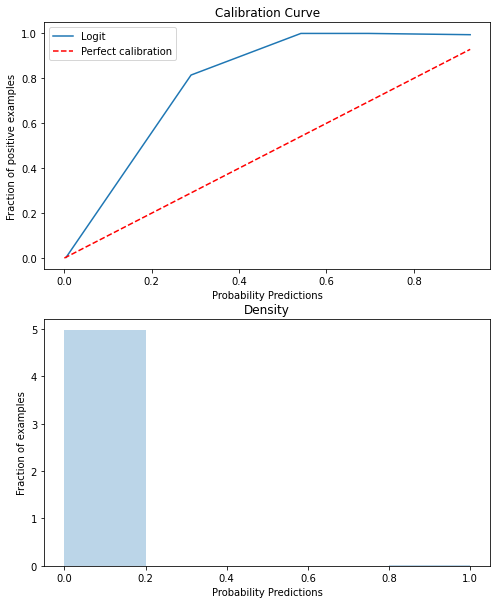

In [10]:
plot_calibration_curve(y_test, probs, bins=5, strategy='uniform')

## Probability Re-calibration

In [11]:
# Isotonic calibration

clf_isotonic = CalibratedClassifierCV(rf, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(rf, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test, y_test)
prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

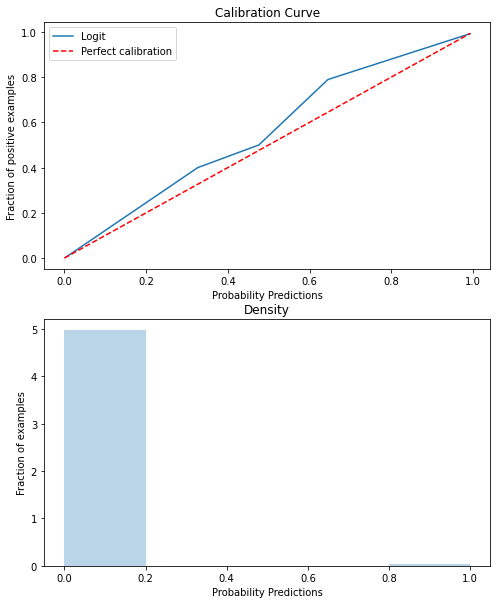

In [12]:
plot_calibration_curve(y_test, prob_isotonic, bins=5, strategy='uniform')

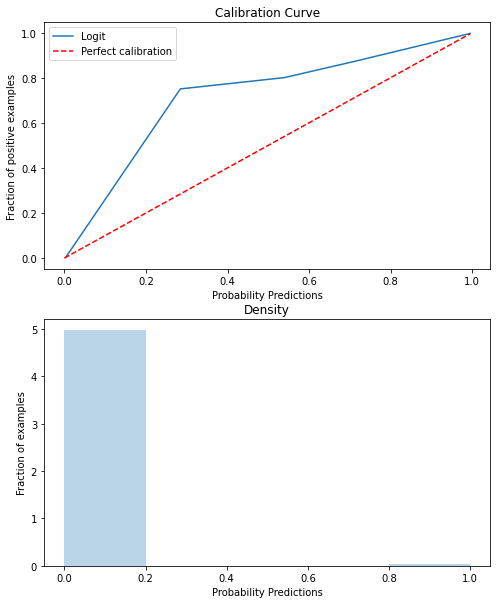

In [13]:
plot_calibration_curve(y_test, prob_sigmoid, bins=5, strategy='uniform')

As expected, the Isotonic calibration works better.